In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Loaded image path: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0815.png
Image loaded successfully: True


(np.float64(-0.5), np.float64(274.5), np.float64(182.5), np.float64(-0.5))

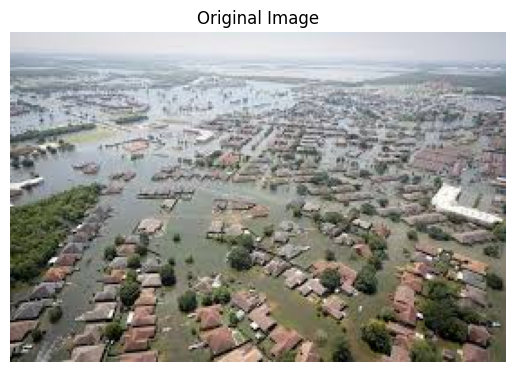

In [31]:
dataset_path = "/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)"

img = None
img_path = None

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is not None:
                break
    if img is not None:
        break

print("Loaded image path:", img_path)
print("Image loaded successfully:", img is not None)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

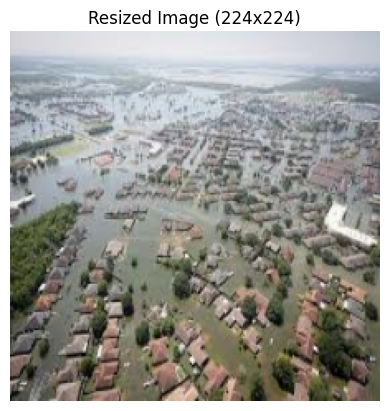

In [32]:
resized_img = cv2.resize(img, (224, 224))

plt.imshow(resized_img)
plt.title("Resized Image (224x224)")
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

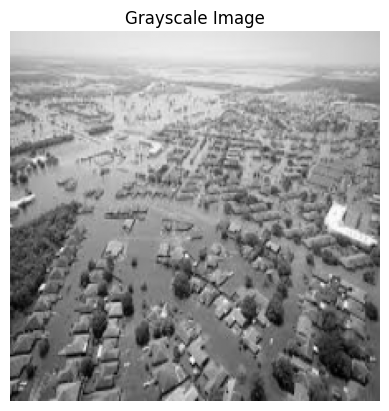

In [33]:
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

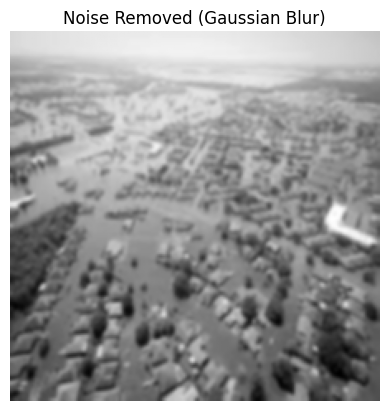

In [34]:
blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)

plt.imshow(blur_img, cmap='gray')
plt.title("Noise Removed (Gaussian Blur)")
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

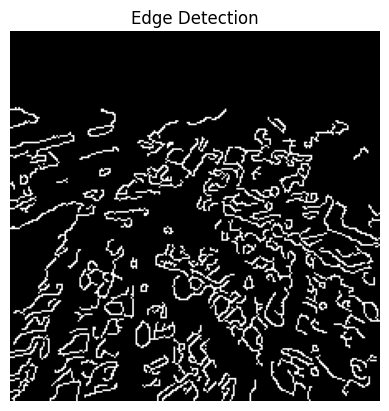

In [35]:
edges = cv2.Canny(blur_img, 100, 200)

plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis("off")


In [36]:
normalized_img = resized_img / 255.0

print("Pixel range after normalization:", 
      normalized_img.min(), normalized_img.max())


Pixel range after normalization: 0.0 1.0


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

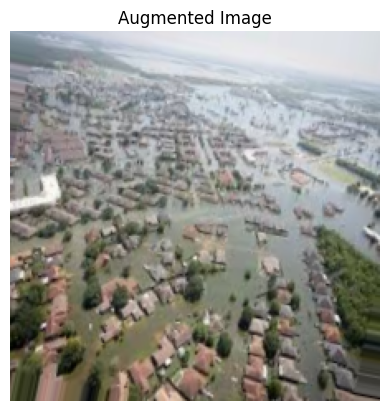

In [37]:
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2
)

sample = np.expand_dims(resized_img, axis=0)  # (1,224,224,3)

augmented = datagen.flow(sample, batch_size=1)

aug_img = augmented[0][0].astype("uint8")  # FIXED

plt.imshow(aug_img)
plt.title("Augmented Image")
plt.axis("off")


In [38]:
dataset_path = "/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)"
IMG_SIZE = 224

processed_images = []
labels = []

class_names = sorted(os.listdir(dataset_path))

for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.isdir(class_path):
        continue
    
    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        
        #CRITICAL SAFETY CHECK
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        
        processed_images.append(img)
        labels.append(class_index)

processed_images = np.array(processed_images)
labels = np.array(labels)

print(" Total images processed:", processed_images.shape[0])
print(" Image shape:", processed_images.shape[1:])
print(" Labels shape:", labels.shape)
print("Classes:", class_names)


 Total images processed: 1275
 Image shape: (224, 224, 3)
 Labels shape: (1275,)
Classes: ['Damaged_Infrastructure', 'Fire_Disaster', 'Human_Damage', 'Land_Disaster', 'Non_Damage', 'Water_Disaster']


In [39]:
print("Final Image Shape:", processed_images[0].shape)
print("Sample Label:", labels[0])


Final Image Shape: (224, 224, 3)
Sample Label: 2


In [40]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print("Original labels:", np.unique(labels))
print("Encoded labels:", np.unique(labels_encoded))


Original labels: [2 5]
Encoded labels: [0 1]


In [41]:
X = processed_images
y = labels_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [42]:
num_classes = len(np.unique(y))

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)


y_train_cat shape: (1020, 2)
y_test_cat shape: (255, 2)


In [43]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=10,
    batch_size=32
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7523 - loss: 0.5426 - val_accuracy: 0.8118 - val_loss: 0.4383
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7986 - loss: 0.4693 - val_accuracy: 0.8078 - val_loss: 0.4084
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8257 - loss: 0.3534 - val_accuracy: 0.8510 - val_loss: 0.3467
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8347 - loss: 0.3484 - val_accuracy: 0.8706 - val_loss: 0.3133
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8689 - loss: 0.2986 - val_accuracy: 0.8706 - val_loss: 0.3042
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9016 - loss: 0.2524 - val_accuracy: 0.9020 - val_loss: 0.2612
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9214 - loss: 0.2295 - val_accuracy: 0.8980 - val_loss: 0.2592
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9238 - loss: 0.2234 - val_accuracy: 0.8863 - val_loss:

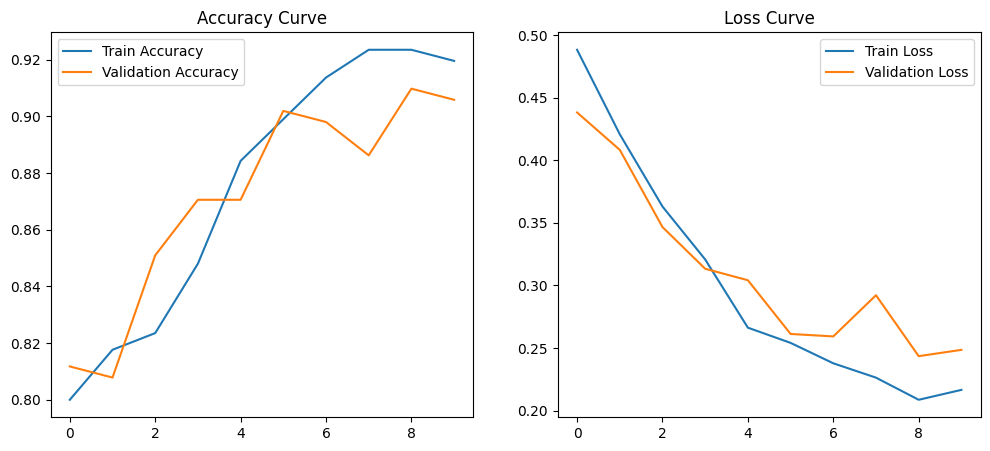

In [45]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()


In [46]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step


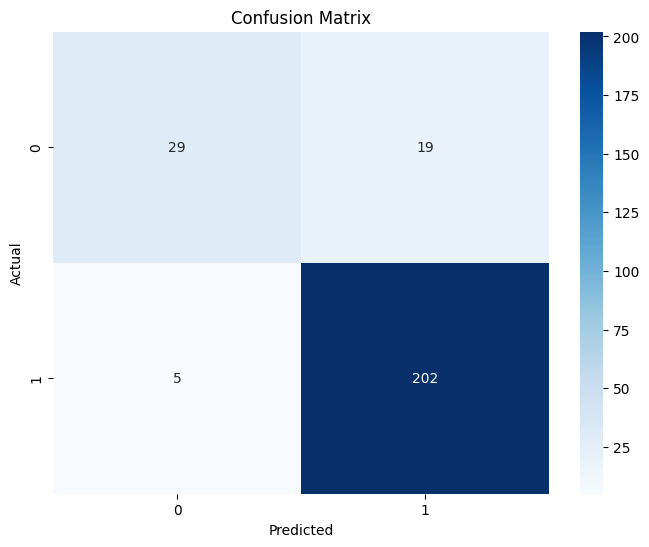

In [47]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.60      0.71        48
           1       0.91      0.98      0.94       207

    accuracy                           0.91       255
   macro avg       0.88      0.79      0.83       255
weighted avg       0.90      0.91      0.90       255



8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step
y_test length: 255
y_pred_prob_pos length: 255


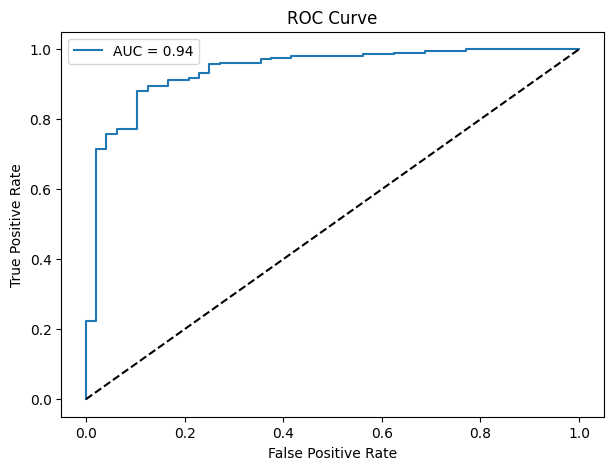

In [49]:
y_pred_prob = model.predict(X_test)

y_pred_prob_pos = y_pred_prob[:, 1]

print("y_test length:", len(y_test))
print("y_pred_prob_pos length:", len(y_pred_prob_pos))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_pos)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
